<a href="https://colab.research.google.com/github/umerkay/satellite-imaging-segmentation/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

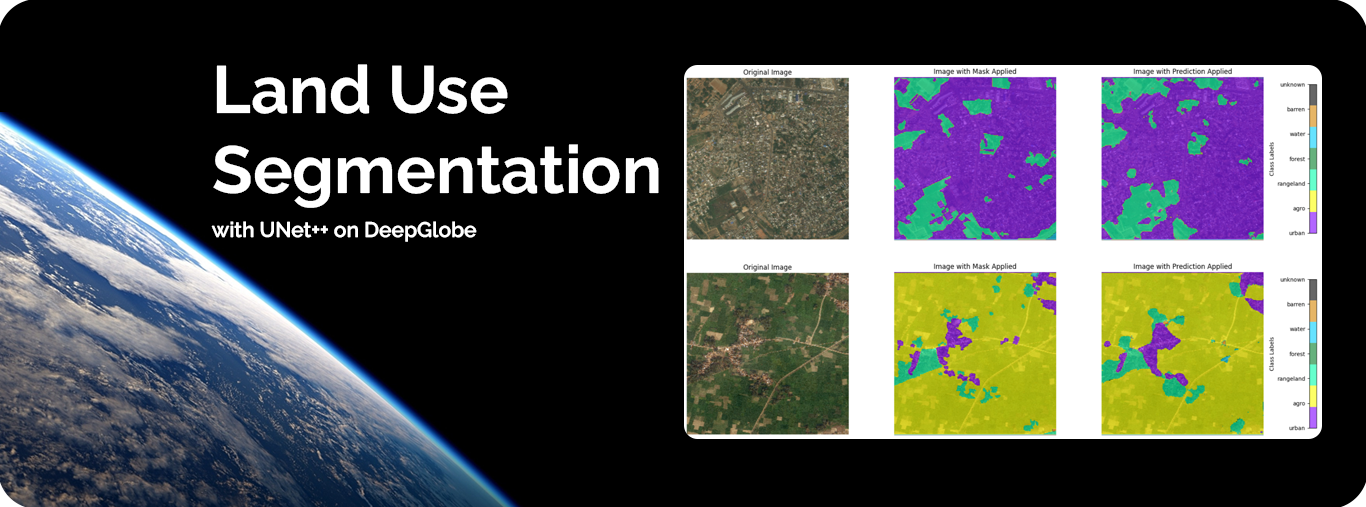

# Land Use Segmentation with UNet
This notebook uses data that is part of the [DeepGlobe Challenge](https://arxiv.org/abs/1805.06561). A UNet architecture is used to predict segmentation maps of satellite imagery. The masks classify between 7 different classes for land use: urban, agriculture, rangeland, forest, water, barren, and unknown.

The dataset used in this notebook includes only the training set from the original land use segmentation challenge, as the challenge is over and ground truth masks for validation and test sets are no longer available. Masks were included as RGB color maps, with different (often overlaying) colors representing the different classes. Hence, the data is pre-processed to convert to class labels for training and evaluation.

This implementation is inspired in-part by this [medium article](https://baratam-tarunkumar.medium.com/land-cover-classification-with-u-net-aa618ea64a1b).

## Class Imbalance
Training data used in this challenge has a great degree of class imbalance. Agricultural land, for example, is prevalant in the training data. The model will thus tend to prefer the over represented classes in order to do well in the loss function. This is tackled by calculating and using class weights in the loss calculation.

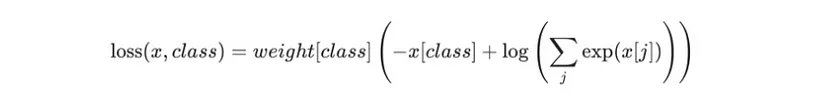

# Imports

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torchvision.transforms as T
from sklearn.metrics import f1_score
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid
%matplotlib inline
import albumentations as A
!pip install opendatasets --upgrade --quiet
import opendatasets as od
import zipfile
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


# Data

##Dataset

In [2]:
def getData(DATA_URL):
  od.download(DATA_URL)
  with zipfile.ZipFile("/content/deepglobe2018-landcover-segmentation-traindataset/data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

DATA_URL = 'https://www.kaggle.com/datasets/geoap96/deepglobe2018-landcover-segmentation-traindataset'

getData(DATA_URL)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: umerkay
Your Kaggle Key: ··········


100%|██████████| 1.93G/1.93G [01:36<00:00, 21.5MB/s]


Define global variables for Dataset

In [3]:
DATA_DIR = '/content/data/data'
VAL_DIR = DATA_DIR + '/test_data'
TRAIN_DIR = DATA_DIR + '/training_data'

colors = ['#8000FF', '#FCFF00', '#00FFAB', '#007D26', '#00D0FF', '#D68400', '#000000']
class_labels = ['urban', 'agro', 'rangeland', 'forest', 'water', 'barren', 'unknown']
colormap = ListedColormap(colors)

Dataset Class

In [4]:
from torchvision import transforms as T
import cv2
from glob import glob

class SatDataSet(Dataset):

    def __init__(self, path, mean, std, transform=None):
        self.img_path = path + "/images"
        self.mask_path = path + "/masks"

        name = []
        for dirname, _, filenames in os.walk(self.img_path):
            for filename in filenames:
                name.append(filename.split('_')[0])

        self.X = pd.DataFrame({'id': name}, index = np.arange(0, len(name))).values
        print("Number of images found: ", len(self.X))

        self.transform = transform
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def RGB_2_class_idx(self, mask_to_be_converted):
      mapping = {(0, 255, 255): 0,     #urban_land
                (255, 255, 0): 1,    #agriculture
                (255, 0, 255): 2,    #rangeland
                (0, 255, 0): 3,      #forest_land
                (0, 0, 255): 4,      #water
                (255, 255, 255): 5,  #barren_land
                (0, 0, 0): 6}        #unknown
      temp = np.array(mask_to_be_converted)
      temp = np.where(temp>=128, 255, 0)

      class_mask=torch.from_numpy(temp)
      h, w = class_mask.shape[1], class_mask.shape[2]
      mask_out = torch.zeros(h, w, dtype=torch.long)
      for k in mapping:
          idx = (class_mask == torch.tensor(k, dtype=torch.uint8).unsqueeze(1).unsqueeze(2))
          validx = (idx.sum(0) == 3)
          mask_out[validx] = torch.tensor(mapping[k], dtype=torch.long)

      return mask_out

    def __getitem__(self, i):
        idx = self.X[i][0]


        img = cv2.imread(self.img_path + "/" + idx + '_sat.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + "/" + idx + '_mask.png')
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = self.RGB_2_class_idx(mask.transpose(2,0,1))
        return {
            'image': img.type(torch.FloatTensor),
            # 'mask': torch.from_numpy(mask).type(torch.FloatTensor)
            'mask': mask
        }

## Data Loaders

In [5]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
imsize=256
batch_size= 8

t_train = A.Compose([A.Resize(imsize, imsize, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(),
                     A.GaussNoise()])
t_val = A.Compose([A.Resize(imsize, imsize, interpolation=cv2.INTER_NEAREST)])

#datasets
train_set = SatDataSet(TRAIN_DIR, mean, std, t_train)
val_set = SatDataSet(VAL_DIR, mean, std, t_val)

#dataloader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Number of images found:  683
Number of images found:  120


## Example Data

We define a helpful show image function to show the image and masks

In [6]:
def showImage(img, mask=None, pred=None, showLegend=False):
    fig, axs = plt.subplots(1, 3 if pred is None else 4, figsize=(15 if pred is None else 20, 5))  # Create a figure with 1 row and 3 columns

    # Plot the original image
    img_np = ((img * torch.tensor(std).view(3, 1, 1)) + torch.tensor(mean).view(3, 1, 1)).permute(1, 2, 0)
    axs[0].imshow(img_np)
    axs[0].axis('off')
    axs[0].set_title('Original Image')

    # Plot the masked image
    if mask is not None:
        axs[1].imshow(img_np)
        zeros_row = torch.zeros(1, mask.shape[1], dtype=torch.float32)
        sixes_row = torch.ones(1, mask.shape[1], dtype=torch.float32) * 6
        msk = axs[1].imshow(torch.cat((zeros_row, mask, sixes_row), dim=0), alpha=0.6, cmap=colormap)
        axs[1].set_title('Image with Mask Applied')
        axs[1].axis('off')

    if pred is not None:
        axs[2].imshow(img_np)
        zeros_row = torch.zeros(1, pred.shape[1], dtype=torch.float32)
        sixes_row = torch.ones(1, pred.shape[1], dtype=torch.float32) * 6
        msk = axs[2].imshow(torch.cat((zeros_row, pred, sixes_row), dim=0), alpha=0.6, cmap=colormap)
        axs[2].set_title('Image with Prediction Applied')
        axs[2].axis('off')

    # Plot the color map as a separate subplot
    if showLegend:
        assert mask is not None, "Mask cannot be none"
        cbar = plt.colorbar(msk, ax=axs[-1], fraction=0.046, pad=0.04, location='left')  # Create a color bar
        cbar.set_label('Class Labels')

        # Set the tick positions and labels
        tick_positions = [0, 1, 2, 3, 4, 5, 6]
        tick_labels = ['urban', 'agro', 'rangeland', 'forest', 'water', 'barren', 'unknown']

        cbar.set_ticks(tick_positions)
        cbar.set_ticklabels(tick_labels)

        axs[-1].axis('off')

    plt.tight_layout()
    plt.show()

torch.Size([8, 3, 256, 256]) torch.Size([8, 256, 256])


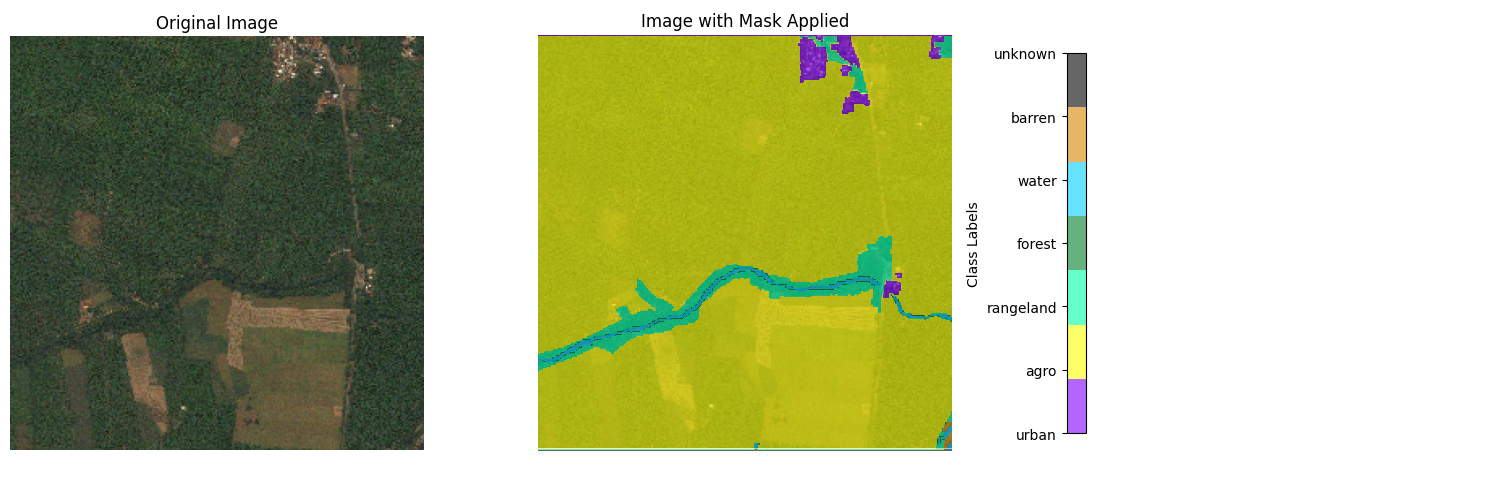

In [72]:
#get image from train loader and display the mask and img
data = next(iter(train_loader))
print(data['image'].shape, data['mask'].shape)
showImage(data['image'][1], data['mask'][1], showLegend = True)

## Class Imbalance

Only run the following code if class counts are not available

In [ ]:
import numpy as np
from tqdm import tqdm

#if class counts are not available, run this. Takes time to run.
def classcount(loader):
    n_train = len(loader)

    class_weight = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])

    with tqdm(total=n_train, desc='Class Count Assessment', unit='batch', disable = False, leave=True) as pbar:
        for batch in loader:
            imgs, true_masks = batch['image'], batch['mask']
            (unique, counts) = np.unique(true_masks, return_counts=True)
            frequencies = np.asarray((unique, counts))
            # print(frequencies.shape)
            for i in range(frequencies.shape[1]):
                class_weight[frequencies[0,i]] += frequencies[1,i]
            pbar.update()

    # print(class_weight)
    class_weight = class_weight[:-1].min()/class_weight
    class_weight[-1]=0

    return class_weight

weights_classes = torch.from_numpy(classcount(train_loader))

Class Count Assessment: 100%|██████████| 86/86 [02:04<00:00,  1.45s/batch]


In [7]:
weights_classes = torch.tensor([0.3001, 0.0581, 0.4032, 0.3110, 1.0000, 0.4279, 0.0000])
weights_classes = weights_classes.to(device=device, dtype=torch.float32)

# Model

##Unet

In [8]:
!pip install -q segmentation-models-pytorch
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=7,                      # model output channels (number of classes in your dataset)
    encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]
)

model.to(device);

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.1 MB/s eta 0:00:00


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 22.2MB/s]


## Efficient Unet++

In [8]:
!pip install -U git+https://github.com/jlcsilva/segmentation_models.pytorch
import segmentation_models_pytorch as smp

model = smp.EfficientUnetPlusPlus(
    encoder_name='timm-efficientnet-b5',
    encoder_depth=5,
    encoder_weights='imagenet',
    decoder_channels=(256, 128, 64, 32, 16),
    squeeze_ratio=1,
    expansion_ratio=1,
    in_channels=3,
    classes=7, activation=None, aux_params=None)

model.to(device);

  Cloning https://github.com/jlcsilva/segmentation_models.pytorch to /tmp/pip-req-build-k9yubwmu
  Running command git clone --filter=blob:none --quiet https://github.com/jlcsilva/segmentation_models.pytorch /tmp/pip-req-build-k9yubwmu
  Resolved https://github.com/jlcsilva/segmentation_models.pytorch to commit 44a5593bfb1c8f2a3f5f23303c02e6f7e2f11170
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 17.8 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-py3-none-any.whl size=96318 sha256=d5f2f42290fa56bb754809219c42ac729705a8d4cf95874246a15c1b00913c0c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6crj27bm/wheels/62/8f/61/617a3d940a6f738b4e551b3e97729743fd1ee4892d5ad65c44
  Created wheel for efficientnet-pytorch: fi

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ra-9a3e5369.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ra-9a3e5369.pth
100%|██████████| 117M/117M [00:07<00:00, 16.5MB/s]


##Utilities

In [9]:
# Calculate pixel accuracy over a batch of images
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

# Calculate mean Intersection-over-Union over a batch of images
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=7):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

###Sample Output

In [10]:
def showPred(img, output, mask, imagesToShow = 1):
  predmask = torch.argmax(output, dim=1)
  for idx in range(imagesToShow):
      showImage(img[idx], mask[idx], predmask[idx].cpu(), showLegend=True)


In [ ]:
data = next(iter(train_loader))
img = data['image']
mask = data['mask']

output = model(img.to(device))

showPred(img, output, mask, 1)

#Training

##Hyperparameters

In [11]:
loss_function = torch.nn.CrossEntropyLoss(weight = weights_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
epochs = 10
checkpoint_path = '/content/checkpoint_norm_aug_tensorboard.pth'
best_val_checkpoint_path = '/content/best_val_checkpoint_norm_aug_tensorboard.pth'

## Training From Scratch

In [12]:
# Initializing variables for starting a new training
train_accuracies = []
val_accuracies = []

train_losses = []
val_losses = []

train_mIoUs = []
val_mIoUs = []

val_mIoU_max = -1

# Start epoch is zero for new training
start_epoch = 0

##Loading Trained Model

In [ ]:
# Loading all variables for continuing training a previously saved model

saved_checkpoint_path = '/content/checkpoint.pth'
checkpoint = torch.load(saved_checkpoint_path)

model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
scheduler.load_state_dict(checkpoint['scheduler'])

start_epoch = checkpoint['trianed_epochs'] + 1

train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']

train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']

val_accuracy_max = checkpoint['val_accuracy_max']

In [13]:
# Inner loop for running the model for 1 epoch over a given loader

def run_1_epoch(model, loss_fn, loader, optimizer = None, train = False):

  if train:
    model.train()
  else:
    model.eval()

  total_correct_preds = 0
  total_loss = 0
  # Number of images we can get by the loader
  total_samples_in_loader = len(loader.dataset)
  # number of batches we can get by the loader
  total_batches_in_loader = len(loader)

  for batch in tqdm(loader):
    image_batch = batch['image'].to(device)
    labels = batch['mask'].to(device)

    if train:
      assert optimizer is not None, "Optimizer must be provided if train=True"
      optimizer.zero_grad()

    output = model(image_batch)
    _, predicted = torch.max(output.data, 1) # the dimension 1 corresponds to max along the rows
    loss = loss_function(output, labels)

    # Backpropagation
    if train:
      loss.backward()
      optimizer.step()

    total_loss += loss.item()

  loss = total_loss / total_batches_in_loader
  accuracy = pixel_accuracy(output, labels)
  mean_IoU = mIoU(output, labels)

  return loss, accuracy, mean_IoU

## Training Loop

In [14]:
# Main training and validation loop for n number of epochs
for epoch in range(start_epoch, epochs):

  # Get the current learning rate from the optimizer
  current_lr = optimizer.param_groups[0]['lr']

  print("Epoch %d: Train \nLearning Rate: %.6f"%(epoch, current_lr))
  train_loss, train_accuracy, train_mIoU  = run_1_epoch(model, loss_function, train_loader, optimizer, train= True)

  # Update the learning rate scheduler
  scheduler.step()

  # Lists for train loss and accuracy for plotting
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)
  train_mIoUs.append(train_mIoU)

  # Validate the model on validation set
  print("Epoch %d: Validation"%(epoch))
  with torch.no_grad():
    val_loss, val_accuracy, val_mIoU  = run_1_epoch(model, loss_function, val_loader, optimizer, train= False)

  # Lists for val loss and accuracy for plotting
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)
  val_mIoUs.append(val_mIoU)

  print('train loss: %.4f'%(train_loss))
  print('val loss: %.4f'%(val_loss))
  print('train_accuracy %.2f' % (train_accuracy))
  print('val_accuracy %.2f' % (val_accuracy))
  print('train_IoU %.2f'%(train_mIoU))
  print('val_IoU %.2f'%(val_mIoU))

  # Save model if validation accuracy for current epoch is greater than
  # all the previous epochs
  if val_mIoU > val_mIoU_max:
    val_mIoU_max = val_mIoU
    print("New max val mean IoU Acheived %.2f. Saving model.\n\n"%(val_mIoU_max))

    checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }
    torch.save(checkpoint, best_val_checkpoint_path)

  else:
    print("val mean IoU did not increase from %.2f\n\n"%(val_mIoU_max))

# Save checkpoint for the last epoch
  checkpoint = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'scheduler': scheduler.state_dict(),
    'trianed_epochs': epoch,
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'train_mIoUs': train_mIoUs,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'val_accuracy_max': val_mIoU_max,
    'val_mIoUs': val_mIoUs,
    'lr': optimizer.param_groups[0]['lr']
    }

  torch.save(checkpoint, checkpoint_path)



Epoch 0: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 0: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 1.5328
val loss: 1.0299
train_accuracy 0.49
val_accuracy 0.59
train_IoU 0.20
val_IoU 0.33
New max val mean IoU Acheived 0.33. Saving model.


Epoch 1: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 1: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.9871
val loss: 1.1720
train_accuracy 0.48
val_accuracy 0.56
train_IoU 0.20
val_IoU 0.32
val mean IoU did not increase from 0.33


Epoch 2: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 2: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.9378
val loss: 0.7204
train_accuracy 0.56
val_accuracy 0.66
train_IoU 0.22
val_IoU 0.40
New max val mean IoU Acheived 0.40. Saving model.


Epoch 3: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 3: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.8156
val loss: 0.7595
train_accuracy 0.64
val_accuracy 0.77
train_IoU 0.31
val_IoU 0.43
New max val mean IoU Acheived 0.43. Saving model.


Epoch 4: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 4: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.7594
val loss: 0.7165
train_accuracy 0.56
val_accuracy 0.77
train_IoU 0.21
val_IoU 0.47
New max val mean IoU Acheived 0.47. Saving model.


Epoch 5: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 5: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.6816
val loss: 0.7194
train_accuracy 0.65
val_accuracy 0.61
train_IoU 0.39
val_IoU 0.27
val mean IoU did not increase from 0.47


Epoch 6: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 6: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.6660
val loss: 0.6374
train_accuracy 0.71
val_accuracy 0.77
train_IoU 0.29
val_IoU 0.50
New max val mean IoU Acheived 0.50. Saving model.


Epoch 7: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 7: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.6268
val loss: 0.6392
train_accuracy 0.73
val_accuracy 0.87
train_IoU 0.39
val_IoU 0.40
val mean IoU did not increase from 0.50


Epoch 8: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 8: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.6256
val loss: 0.6075
train_accuracy 0.65
val_accuracy 0.74
train_IoU 0.43
val_IoU 0.43
val mean IoU did not increase from 0.50


Epoch 9: Train 
Learning Rate: 0.001000


  0%|          | 0/86 [00:00<?, ?it/s]

Epoch 9: Validation


  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 0.5998
val loss: 0.6368
train_accuracy 0.69
val_accuracy 0.76
train_IoU 0.41
val_IoU 0.63
New max val mean IoU Acheived 0.63. Saving model.




#Evaluation

Text(0.5, 1.0, 'Training and val Loss')

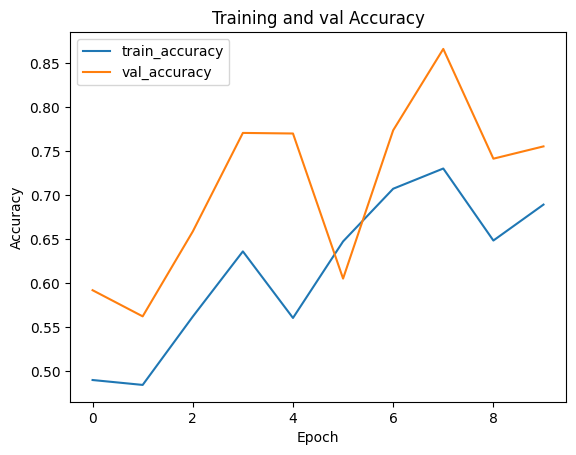

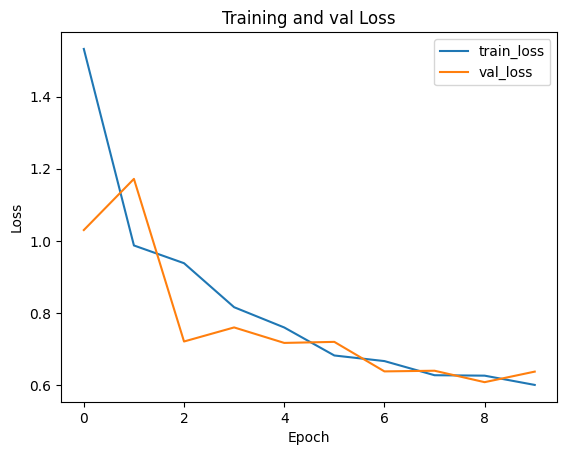

In [16]:
plt.figure()
plt.plot(train_accuracies, label="train_accuracy")
plt.plot(val_accuracies, label="val_accuracy")
plt.legend()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and val Accuracy')

plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val Loss')

## Test Examples

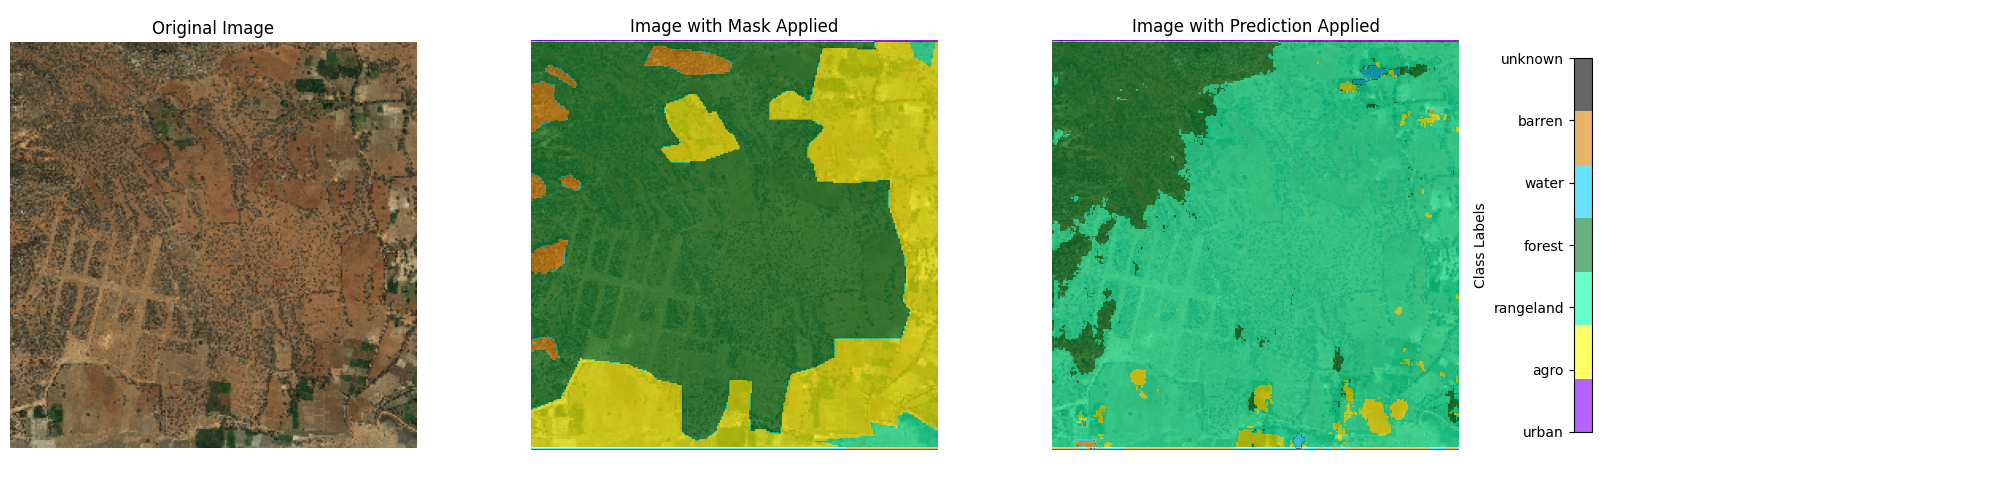

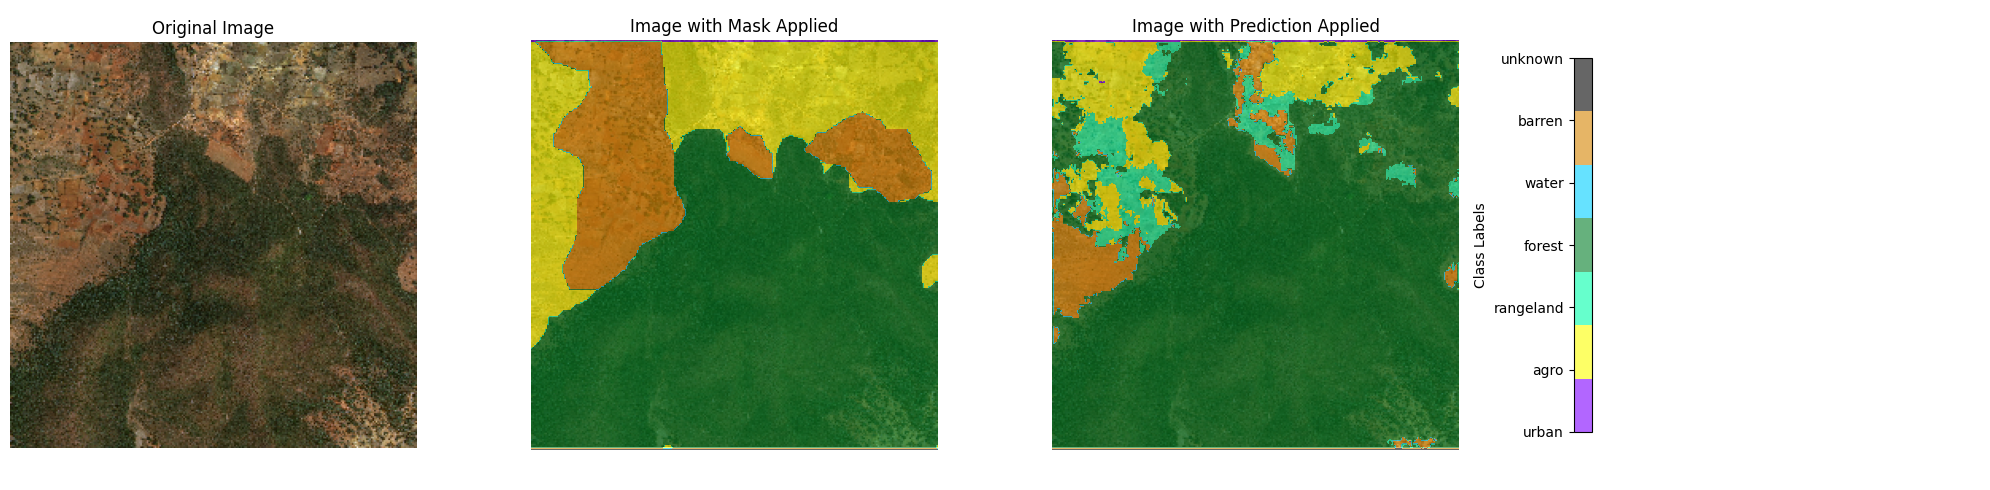

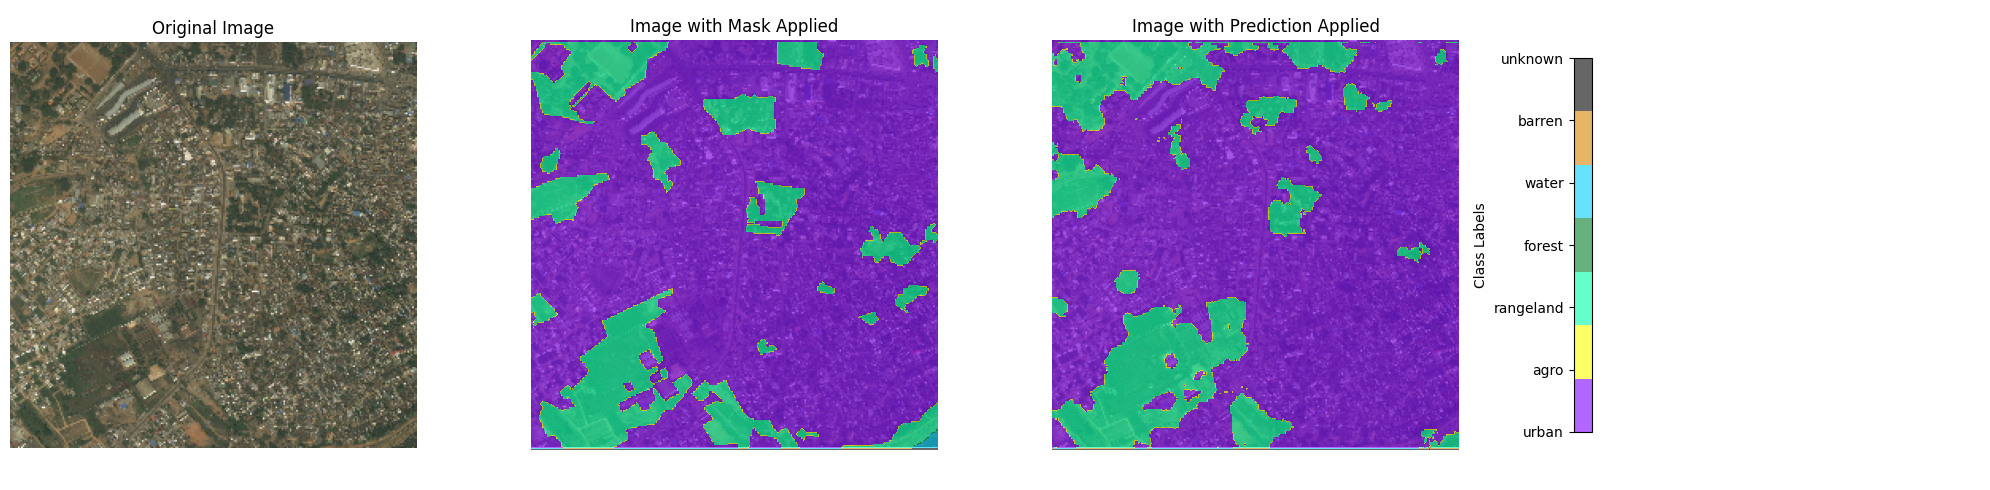

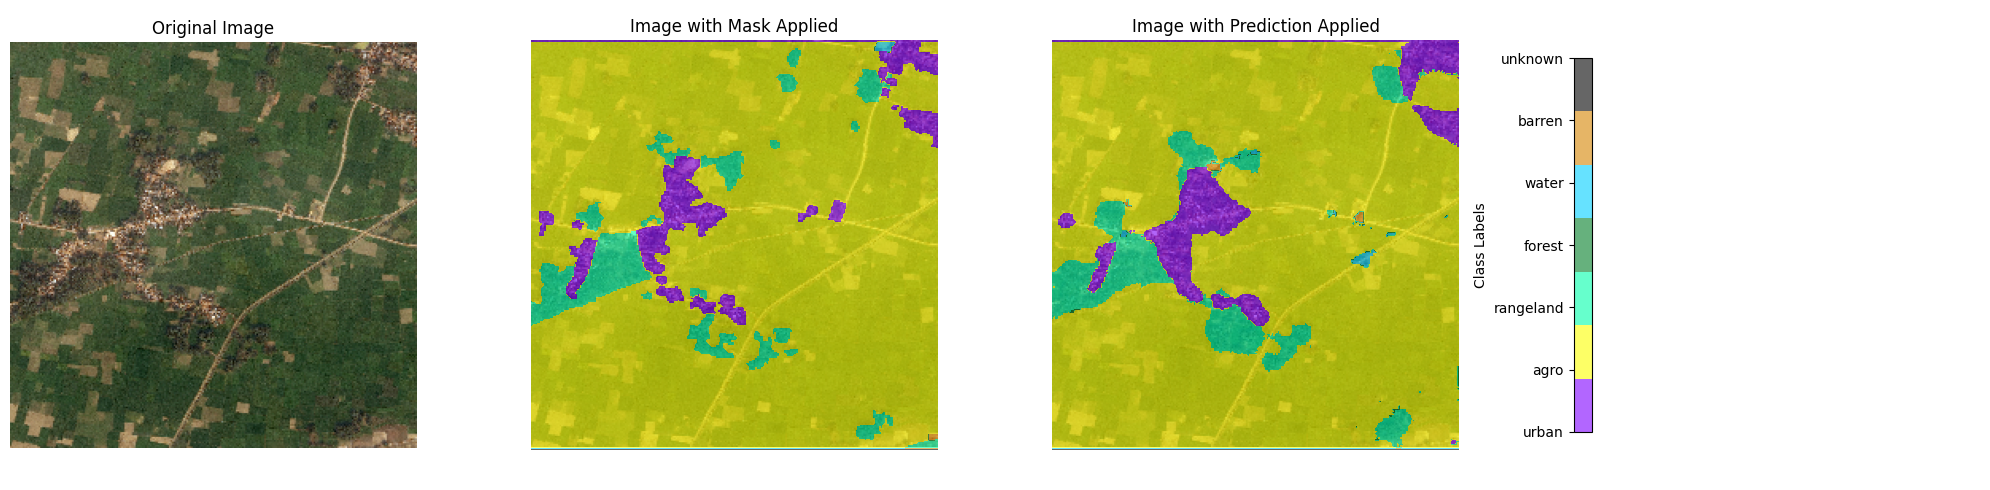

In [18]:
test_loader = DataLoader(val_set, batch_size=4, shuffle=True)

data = next(iter(test_loader))
img = data['image']
mask = data['mask']

output = model(img.to(device))

showPred(img, output, mask, 4)

## Save to Drive

In [22]:
from google.colab import drive
drive.mount('/content/drive')

!cp "/content/best_val_checkpoint_norm_aug_tensorboard.pth" "/content/drive/MyDrive/deep-globe-unetpp.pth"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
